## Libs

In [1]:
import torch
from torch.autograd import Variable

import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

import models
from tacotron2.text import text_to_sequence
from common.utils import load_wav_to_torch, to_gpu
from common.layers import TacotronSTFT
from hparams import Hyperparameters as hp

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Paths to checkpoints

In [3]:
#taco_path = '/workspace/output/new_try_2/sm_bl_lj_1st700_anneal/checkpoint_Tacotron2_1100'
#taco_path = '/workspace/output/pretrained/t2_fp32_torch'
taco_path = '/workspace/output/new_try_2/sm_from_lj_800_anneal/checkpoint_Tacotron2_1900'
wg_path = '/workspace/output/sm_wg/checkpoint_WaveGlow_1750'

## Load models

In [4]:
taco_checkpoint = torch.load(taco_path, map_location='cpu')
wg_checkpoint = torch.load(wg_path, map_location='cpu')

In [5]:
t2 = models.get_model('Tacotron2', taco_checkpoint['config'], to_cuda=True)
wg = models.get_model('WaveGlow', wg_checkpoint['config'], to_cuda=True)

In [6]:
for model, checkpoint in [(t2, taco_checkpoint), (wg, wg_checkpoint)]:
    new_state_dict = {}
    for key, value in checkpoint['state_dict'].items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)

In [7]:
t2.eval()
wg.eval()
print('Done')

Done


## Set speaker and text

In [282]:
text = "Preventing unfair treatment of individuals on the basis of race, gender or ethnicity, for example, been a long-standing concern of civilized societies. However, detecting such discrimination resulting from decisions, whether by human decision makers or automated AI systems, can be extremely challenging."
speaker_id = 1

## Select inference type

In [283]:
#inf_type = 'ref'

### Reference audio

In [284]:
#ref_audio = '/workspace/training_data/blizzard_2013/wavs/CA-MP2-03-013.wav'

#### Listen to ref Audio

In [285]:
#Audio(ref_audio, rate=hp.sampling_rate)

### Or GST token

In [286]:
style_token = None

In [287]:
# if inf_type == 'ref':
#     stft = TacotronSTFT(
#         hp.filter_length, hp.hop_length, hp.win_length,
#         hp.n_mel_channels, hp.sampling_rate, hp.mel_fmin,
#         hp.mel_fmax
#     )

#     audio, sampling_rate = load_wav_to_torch(ref_audio)

#     if sampling_rate != stft.sampling_rate:
#         raise ValueError("{} {} SR doesn't match target {} SR".format(
#             sampling_rate, stft.sampling_rate))

#     audio_norm = audio / hp.max_wav_value
#     audio_norm = audio_norm.unsqueeze(0)
#     audio_norm = Variable(audio_norm, requires_grad=False)
#     ref_mel = stft.mel_spectrogram(audio_norm)
#     ref_mel = torch.squeeze(ref_mel, 0)

#     ref_mel = ref_mel.unsqueeze(0)
    
#     ref_mel = to_gpu(ref_mel)
# elif inf_type == 'token':
#     pass

## Infer

In [303]:
inputs = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
inputs = torch.from_numpy(inputs).to(device='cuda', dtype=torch.int64)
#input_lengths = torch.IntTensor([inputs.size(1)]).cuda().long()
speaker_id = torch.IntTensor([speaker_id]).cuda().long()

In [304]:
embedded_speaker = t2.speakers_embedding(speaker_id)

In [305]:
embedded_speaker

tensor([[-9.8598e-02, -6.6626e-01, -5.2293e-05, -5.6351e-01,  8.4481e-05,
         -4.4515e-02,  2.5602e-02, -7.4654e-05, -7.5098e-05,  1.2892e-01,
         -1.3559e-01,  8.8609e-01, -7.5219e-05,  7.4093e-01, -5.6103e-02,
          7.6962e-05]], device='cuda:0', grad_fn=<EmbeddingBackward>)

In [306]:
with torch.no_grad():
    _, mel, _, _ = t2.infer(inputs, speaker_id)
    audio = wg.infer(mel)

merged_outputs torch.Size([1, 304, 528])


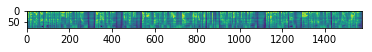

In [307]:
plt.imshow(mel.squeeze(0).detach().cpu().numpy())

In [308]:
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

In [309]:
Audio(audio_numpy, rate=rate)

In [310]:
#Audio(audio_numpy, rate=rate)